In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [4]:
from pathlib import Path
DATA_DIR = Path('../data/KPI-Anomaly-Detection/Preliminary_dataset')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

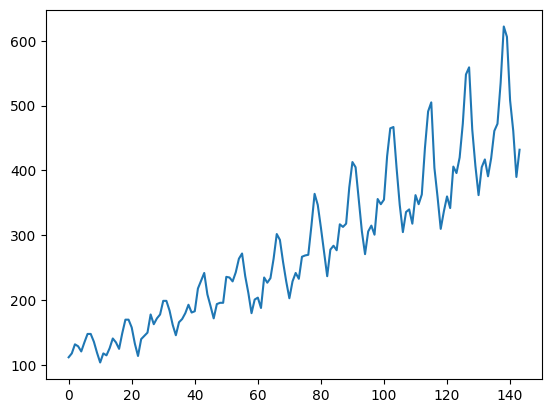

In [6]:
import pandas as pd
 
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [7]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [9]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [11]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([91, 5, 1]) torch.Size([91, 5, 1])
torch.Size([43, 5, 1]) torch.Size([43, 5, 1])


In [12]:

import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [71]:

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data as data
 
# df = pd.read_csv('airline-passengers.csv')
# timeseries = df[["Passengers"]].values.astype('float32')
 
# # train-test split for time series
# train_size = int(len(timeseries) * 0.67)
# test_size = len(timeseries) - train_size
# train, test = timeseries[:train_size], timeseries[train_size:]

In [15]:

 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [16]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


Epoch 0: train RMSE 226.2407, test RMSE 425.4720
Epoch 100: train RMSE 176.2145, test RMSE 372.9882
Epoch 200: train RMSE 138.9531, test RMSE 332.0973
Epoch 300: train RMSE 109.0692, test RMSE 296.2616
Epoch 400: train RMSE 86.7682, test RMSE 265.2941
Epoch 500: train RMSE 66.3404, test RMSE 233.4069
Epoch 600: train RMSE 52.5068, test RMSE 206.7197
Epoch 700: train RMSE 42.5763, test RMSE 183.2024
Epoch 800: train RMSE 35.4158, test RMSE 162.6712
Epoch 900: train RMSE 30.4722, test RMSE 144.6375
Epoch 1000: train RMSE 27.1040, test RMSE 129.6112
Epoch 1100: train RMSE 24.7396, test RMSE 117.4794
Epoch 1200: train RMSE 23.2705, test RMSE 107.4132
Epoch 1300: train RMSE 22.3018, test RMSE 100.1879
Epoch 1400: train RMSE 21.2249, test RMSE 93.8962
Epoch 1500: train RMSE 21.2865, test RMSE 88.3666
Epoch 1600: train RMSE 20.4617, test RMSE 85.5336
Epoch 1700: train RMSE 20.0382, test RMSE 83.2848
Epoch 1800: train RMSE 19.5259, test RMSE 80.2518
Epoch 1900: train RMSE 19.2699, test RMSE 78

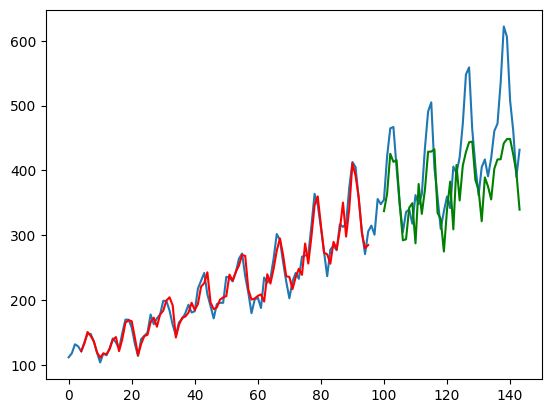

In [17]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


In [19]:
X_batch.shape

torch.Size([4, 4, 1])

In [25]:
b = next(iter(loader))

In [28]:
len(b)

2

In [30]:
b[1].shape

torch.Size([8, 4, 1])

In [31]:
b[0].shape

torch.Size([8, 4, 1])

## TranAD format

In [36]:
!ls ../../trash/TranAD/processed/NAB

ambient_temperature_system_failure_labels.npy
ambient_temperature_system_failure_test.npy
ambient_temperature_system_failure_train.npy
cpu_utilization_asg_misconfiguration_labels.npy
cpu_utilization_asg_misconfiguration_test.npy
cpu_utilization_asg_misconfiguration_train.npy
ec2_request_latency_system_failure_labels.npy
ec2_request_latency_system_failure_test.npy
ec2_request_latency_system_failure_train.npy
machine_temperature_system_failure_labels.npy
machine_temperature_system_failure_test.npy
machine_temperature_system_failure_train.npy
nyc_taxi_labels.npy
nyc_taxi_test.npy
nyc_taxi_train.npy
rogue_agent_key_hold_labels.npy
rogue_agent_key_hold_test.npy
rogue_agent_key_hold_train.npy
rogue_agent_key_updown_labels.npy
rogue_agent_key_updown_test.npy
rogue_agent_key_updown_train.npy


In [37]:
from pathlib import Path
DATA_DIR = Path('../../trash/TranAD/processed/NAB')

In [42]:
tr = np.load(DATA_DIR/'ambient_temperature_system_failure_train.npy')
y = np.load(DATA_DIR/'ambient_temperature_system_failure_labels.npy')

In [43]:
tr

array([[0.43186209],
       [0.47842565],
       [0.46652145],
       ...,
       [0.50715306],
       [0.49945827],
       [0.52583989]])

In [44]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## attention example

https://stackoverflow.com/questions/65642832/inputs-to-the-nn-multiheadattention

https://stackoverflow.com/questions/71464582/how-to-use-pytorchs-nn-multiheadattention

In [72]:
df = pd.read_csv('airline-passengers.csv')
# df.to_csv('airline-passengers.csv', index=False)
df = df[["Passengers"]]
df['y'] = df['Passengers']
df.drop(columns='Passengers', inplace=True)

In [73]:
for lag in range(1, 10):
    df[f'lag_{lag}'] = df['y'].shift(lag)
df.dropna(inplace=True)

In [74]:
df.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
9,119,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
10,104,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
11,118,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
12,115,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
13,126,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [77]:
import torch.nn as nn

embed_dim = 8
num_heads = 4
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

In [78]:
multihead_ttn

NameError: name 'multihead_ttn' is not defined

In [ ]:
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
attn_output, attn_output_weights = multihead_attn(query, key, value)